# Initial code from Daria

In [1]:
import numpy as np
import xarray as xr
import os 

# Constants
g = 9.81  # Gravity (m/s²)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)
lat_to_rad = np.pi / 180.0

def coriolis(lat):
    """Calculate the Coriolis parameter."""
    return 2 * omega * np.sin(lat * lat_to_rad)


# SSH = SLA

def calculate_geostrophic_velocities_cpu(ssh, lat, lon):
    """Calculate geostrophic velocities from SSH."""
    # Calculate spatial gradients of SSH
    print(ssh.shape)
    dssh_dy = np.gradient(ssh, axis=1)  # Gradient along latitude
    dssh_dx = np.gradient(ssh , axis=2)  # Gradient along longitude

    # Convert lat/lon to meters for gradient scaling
    lat_spacing = np.gradient(lat) * 111e3  # Convert degrees to meters
    lon_spacing = np.gradient(lon) * 111e3 * np.cos(lat[:, None] * lat_to_rad)  # Broadcast lat to match SSH shape

    # Adjust gradients to physical units (m/m)
    dssh_dx /= lon_spacing
    dssh_dy /= lat_spacing[:, None]

    # Coriolis parameter
    f = coriolis(lat)
    #f_masked = np.where(f == 0, np.nan, f)  # Replace zero values with NaN to prevent division by zero
    f_masked = np.where(np.abs(lat) < 20, np.nan, f) #1e-5 before 18/02/2025

    # Geostrophic velocities
    ugos = -g / f_masked[:, None] * dssh_dy  # u-component
    vgos = g / f_masked[:, None] * dssh_dx  # v-component

    return ugos, vgos
    
# var = ssh ? 
def retreive_geos_velocities(maps, var_name):
    maps = maps.copy()
    mdt_maps = xr.open_dataset("/Odyssey/public/duacs/cnes_obs-sl_glo_phy-mdt_my_0.125deg_P20Y_multi-vars_179.94W-179.94E_89.94S-89.94N_2003-01-01.nc").isel(time=0).expand_dims({'time': maps.time.values}, axis=0)
    #mdt_maps = xr.open_dataset("/Odyssey/public/duacs/1993_2013/duacs_global_0.25deg_1993_2013_mdt.nc").expand_dims({'time': maps.time.values}, axis=0)
    
    print(maps[var_name].values[0].shape[-1])
    print(mdt_maps.mdt.values.shape[-1])

    if(maps[var_name].values[0].shape[-1] != mdt_maps.mdt.values.shape[-1]):
        # Define new latitude and longitude grids
        new_lat = np.linspace(-90, 90, mdt_maps.mdt.shape[-2])
        new_lon = np.linspace(0, 360, mdt_maps.mdt.shape[-1])
        # Interpolate dataset
        maps = maps.interp(latitude=new_lat, longitude=new_lon, method="linear")
    
    diff_x = mdt_maps.mdt.values.shape[1] - maps[var_name].values.shape[-2]
    diff_y = mdt_maps.mdt.values.shape[2] - maps[var_name].values.shape[-1]
    
    if(var_name == "sla"):
        sla = maps[var_name].values #- mdt_maps.mdt.values[:, diff_x : , diff_y : ]  # Assuming variable name is 'out'
    else:
        sla = maps[var_name].values - mdt_maps.mdt.values[:, diff_x : , diff_y : ]  # Assuming variable name is 'out'
    lat = maps['latitude'].values  # Latitude
    lon = maps['longitude'].values  # Longitude

    # Compute geostrophic velocities on CPU
    ugos_cpu, vgos_cpu = calculate_geostrophic_velocities_cpu(sla, lat, lon)

    maps["ugos"] = (('time', 'latitude', 'longitude'), ugos_cpu)
    maps["vgos"] = (('time', 'latitude', 'longitude'), vgos_cpu)

    # Retreive MDT relative to u and v
    mdt_UV = mdt_maps
    #xr.open_dataset('/Odyssey/private/d21botvy/2023a_SSH_mapping_OSE/data/sad/mdt_cnes_cls18_global.nc')

    # Generate new latitude and longitude values, 
    # Only in case the resolution of ds_maps is not the same as the one of mdt_UV !

    MDT_u = np.repeat(mdt_UV['u'][0].values[np.newaxis, :, :], maps.time.values.shape[0], axis=0) # 337 IS THE NB OF DAYS THAT DS_MAPS CONTAIN
    MDT_v = np.repeat(mdt_UV['v'][0].values[np.newaxis, :, :],  maps.time.values.shape[0], axis=0) # 337 IS THE NB OF DAYS THAT DS_MAPS CONTAIN
    
    ugos_cpu += MDT_u
    vgos_cpu += MDT_v

    maps["ugos"] = (('time', 'latitude', 'longitude'), ugos_cpu)
    maps["vgos"] = (('time', 'latitude', 'longitude'), vgos_cpu)

    return maps

In [ ]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-01-02'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
method_name = 'stat_uv_glo12'
stat_output_filename = f'{output_dir}/stat_ssh_stat_uv_glo12_test_global.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_ssh_stat_uv_glo12_test_global.nc'    # output spectral analysis filename
segment_lenght = 1000.  
glo12_paths ='/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_4th.nc'
ds_maps =xr.open_mfdataset(glo12_paths)

restricted = False

leadtime = [0]

one_day = True

#ds_maps = get_preprocessed_rec_mercator_forecast(glo12_paths, leadtime_index=leadtime)
ds_maps_leadtime_i = ds_maps.sel(time=slice(time_min, time_max)).rename({'zos':'ssh', 'lat':'latitude', 'lon':'longitude'})
ds_maps_leadtime_i["ssh"] = ds_maps_leadtime_i.ssh - ds_maps_leadtime_i.ssh.mean(skipna=True)

ds_maps_leadtime_i["longitude"] = (ds_maps_leadtime_i["longitude"] % 360).where(ds_maps_leadtime_i["longitude"] != 360, 0)
lon_unique, index = np.unique(ds_maps_leadtime_i.coords["longitude"], return_index=True)
ds_maps_leadtime_i = ds_maps_leadtime_i.isel(longitude=index)
ds_maps_leadtime_i.latitude.attrs['units'] = 'degrees_north'
ds_maps_leadtime_i.longitude.attrs['units'] = 'degrees_east'
ds_maps_leadtime_i = ds_maps_leadtime_i.sortby(['time', 'longitude', 'latitude'])

m_var_glo12, s_var = ds_maps_leadtime_i.ssh.pipe(lambda da: (da.mean().values.item(), da.std().values.item()))

## ???
#m_var_sat, s_var = ds_alg.ssh.pipe(lambda da: (da.mean().values.item(), da.std().values.item()))
#offset_ssh = m_var_sat - m_var_glo12
offset_ssh=0

ds_maps_leadtime_i['ssh'] = ds_maps_leadtime_i['ssh'] + offset_ssh

ds_maps_leadtime_i = retreive_geos_velocities(ds_maps_leadtime_i, "ssh")


1440
2880
(2, 1440, 2880)


In [65]:
ds_maps_leadtime_i.time[index_time].values

numpy.datetime64('2019-01-01T00:00:00.000000000')

Text(0, 0.5, 'ssh?[m]')

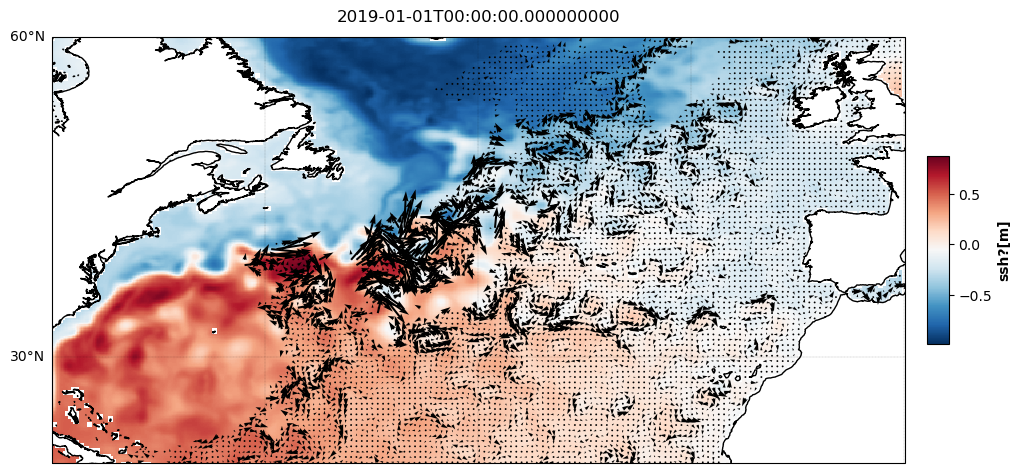

In [69]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.mod_plot import *
import warnings
warnings.filterwarnings("ignore")

index_time = 0

ds_map_plot = ds_maps_leadtime_i.sel(time=ds_maps_leadtime_i.time[index_time],longitude=slice(280,360),latitude=slice(20, 60))


fig, axs = plt.subplots(nrows=1,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11,7.5))


p0 = axs.pcolormesh(ds_map_plot.longitude[:], ds_map_plot.latitude[:], ds_map_plot.ssh[:],cmap='RdBu_r')

filter_arrow = 4
axs.quiver(ds_map_plot.longitude[::filter_arrow], ds_map_plot.latitude[::filter_arrow], ds_map_plot.ugos[::filter_arrow,::filter_arrow],ds_map_plot.vgos[::filter_arrow,::filter_arrow])


axs.set_title(ds_maps_leadtime_i.time[index_time].values)

axs.coastlines(resolution='10m', lw=1)
# optional add grid lines
p0.axes.gridlines(color='black', alpha=0., linestyle='--')
# draw parallels/meridiens and write labels
gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.2, color='black', alpha=0.5, linestyle='--')
# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}


cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
cbar = fig.colorbar(p0, cax=cax, orientation='vertical')
cax.set_ylabel('ssh?[m]', fontweight='bold')


In [ ]:
'''
    Drifters Velocities
'''

ds_maps_leadtime_i = retreive_geos_velocities(ds_maps_leadtime_i, "ssh")
ds_maps_leadtime_i.to_netcdf('/Odyssey/public/glorys/rec/glorys4_global_1patch10y/nrt_2023_global_4/GEOS_test_data_{}.nc'.format(14+leadtime))
if(restricted):
    ds_drifter_restricted_time = ds_drifter.sel(TIME=numpy_restrict_time_alongtrack(ds_drifter.TIME.values, ds_maps_leadtime_i.time.values, days_offset=0.5))
else:
    ds_drifter_restricted_time = ds_drifter

ds_drifter_restricted_time = (
    ds_drifter_restricted_time.groupby("trajectory")
    .map(lambda group: group.rolling(TIME=24, center=True).mean())
)
ds_interp = run_interpolation_drifters(ds_maps_leadtime_i, ds_drifter_restricted_time, time_min, time_max, restricted)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')

print('GLO12 Leadtime ' + str(leadtime))

'''
    UV scores
'''
    compute_stat_scores_uv(ds_interp, f'{output_dir}/new_MDT_stat_uv_glo12_geos_'+str(leadtime) + '.nc',method_name=method_name)